In [1]:
import itertools
import random
from collections import Counter
import joblib
import pickle
import pandas as pd
import numpy as np
import re
from keras import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM
from keras.utils.np_utils import to_categorical
from nltk.corpus import stopwords
from parsivar import Normalizer
import emoji
import emojies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [224]:
class CleanText:
    def __init__(self, data_frame, column_name):
        self.cln_list = data_frame[column_name].tolist()
    def __new__(cls, data_frame, column_name,*args, **kwargs):
        data_frame[column_name] = data_frame[column_name].apply(lambda x: x[:400])
        return super().__new__(cls,*args, **kwargs)
    def clean_punctual(self):
        tmp_lst = list(map(lambda x: re.sub(r'https?:\S*', ' ', x), self.cln_list))
        tmp_lst = list(map(lambda x: re.sub(r'@[A-Za-z0-9]\S+', ' ', x), tmp_lst))
        tmp_lst = list(map(lambda x: re.sub(r'[0-9]\S+', ' ', x), tmp_lst))
        self.cln_list = list(map(lambda x: re.sub(r'#|_|:|/d+', ' ', x), tmp_lst))
        return self.cln_list
    def normalize_text(self):
        normalizer = Normalizer(pinglish_conversion_needed=True)
        cln_list = list(map(lambda x: normalizer.normalize(x), self.cln_list))
        self.cln_list = list(map(lambda x: ''.join(ch for ch, _ in itertools.groupby(x)), cln_list))
        return self.cln_list
    def remove_stop_words(self):
        stop_words = set(stopwords.words('RD_persian_01'))
        self.cln_list = list(map(lambda x: ' '.join([w for w in x.split() if not w in stop_words]), self.cln_list))
        return self.cln_list
    def extract_emojis(self):
        self.cln_list = list(map(lambda x: ''.join((' '+c+' ') if c in emoji.UNICODE_EMOJI['en'] else c for c in x), self.cln_list))
        return self.cln_list
    def convert_emojies(self):
        self.cln_list = list(map(lambda x: emojies.replace(x), self.cln_list))
        return self.cln_list
    def frequency_words(self):
        freq = dict(Counter(" ".join(self.cln_list).split()))
        sort_orders = sorted(freq.items(), key=lambda x: x[1], reverse=True)
        sort_orders = sort_orders[:8000]
        # print(sort_orders)
        print(len(sort_orders))
        most_common_word = [i[0] for i in sort_orders]
        most_common_word = set(most_common_word)
        # print(most_common_word)
        print(len(most_common_word))
        self.cln_list = list(map(lambda x: ' '.join([w for w in x.split() if w in most_common_word]), self.cln_list))
        return self.cln_list


In [225]:
class EncodeText:
    def __init__(self,train_text):
        self.train_text = train_text
    def create_tokenizer(self):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(self.train_text)
        return tokenizer
    def encode_text(self,tokenizer, input_list, max_length):
        # integer encode
        encoded = tokenizer.texts_to_sequences(input_list)
        # pad encoded sequences
        padded = pad_sequences(encoded, maxlen=max_length, padding='post')
        return padded
    def label_encoder(self, tag):
        le = LabelEncoder()
        tmp_tag = le.fit_transform(tag)
        encode_tag = to_categorical(np.array(tmp_tag))
        return encode_tag

In [4]:
# Add file
# data_df = pd.read_excel('dataset.2.0.0.xlsx', index_col= False)
# fig, ax = plt.subplots()
# ax.hist(data_df['احساس'])
# plt.show()

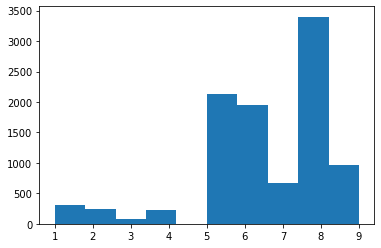

In [226]:
# data_df = pd.read_csv('dataset/comp_dataset2.csv', index_col= False)
data_df = pd.read_excel('dataset/other/posneg.xlsx', index_col= False)
# data_df = pd.read_excel('dataset/other/my_dataset_01.xlsx', index_col= False)
# data_df = pd.read_excel('dataset/other/md_1e4.xlsx', index_col= False)
# data_df = pd.read_excel('dataset/other/lweb.xlsx', index_col= False)
# data_df = pd.read_excel('dataset/other/comp.xlsx', index_col= False)

fig, ax = plt.subplots()
ax.hist(data_df['tag'])
plt.show()

In [227]:
# call_cleantext = CleanText(data_df, 'متن توییت')
call_cleantext = CleanText(data_df, 'caption')
# call_cleantext = CleanText(data_df, 'Text')
get_pun_list = call_cleantext.clean_punctual()
get_ex_emoji = call_cleantext.extract_emojis()
get_emoji_list = call_cleantext.convert_emojies()
get_norm_list = call_cleantext.normalize_text()
get_rm_sw_list = call_cleantext.remove_stop_words()
get_most_com_list = call_cleantext.frequency_words()
# get_most_com_list = get_most_com_list
# Remove None Value Data

8000
8000


In [7]:
get_most_com_list = call_cleantext.frequency_words()

4000
4000


In [253]:
# init_List_prepared = list(map(lambda x: [x[0], x[1]], zip(get_most_com_list, data_df['احساس'])))
# init_List_prepared = list(map(lambda x: [x[0], x[1]], zip(get_most_com_list, data_df['tag'])))
init_List_prepared = list(map(lambda x: [x[0], x[1]], zip(get_most_com_list, data_df['tag'])))
print(len(init_List_prepared))
init_List_prepared = list(filter(lambda x: len(x[0].split())>2, init_List_prepared))
print(len(init_List_prepared))

random.shuffle(init_List_prepared)
#
# var1 = list(filter(lambda x: x[1]=='شادی', init_List_prepared))
# var2 = list(filter(lambda x: x[1]=='خشم', init_List_prepared))
# var3 = list(filter(lambda x: x[1]=='غم', init_List_prepared))
# var4 = list(filter(lambda x: x[1]=='خنثی', init_List_prepared))
# var5 = list(filter(lambda x: x[1]=='امید', init_List_prepared))
# var6 = list(filter(lambda x: x[1]=='ترس', init_List_prepared))
# var7 = list(filter(lambda x: x[1]=='تعجب', init_List_prepared))
# var8 = list(filter(lambda x: x[1]=='تحسین یا اعتماد', init_List_prepared))

var1 = list(filter(lambda x: x[1]==4, init_List_prepared))
var2 = list(filter(lambda x: x[1]==5, init_List_prepared))
var3 = list(filter(lambda x: x[1]==6, init_List_prepared))
var4 = list(filter(lambda x: x[1]==7, init_List_prepared))
var5 = list(filter(lambda x: x[1]==8, init_List_prepared))
var6 = list(filter(lambda x: x[1]==9, init_List_prepared))
var7 = list(filter(lambda x: x[1]==2, init_List_prepared))
var8 = list(filter(lambda x: x[1]==3, init_List_prepared))

# List_prepared = var1[:1500]+var2[:1500]+var3[:1000]+var4[:1000]+var5[:1200]+var6[:700]+var7[:500]+var8[:1500]
# List_prepared = var2[:2000]+var3[:2000]+var5[:2000]
List_prepared = var1[:200]+var2[:200]+var3[:200]+var4[:200]+var5[:200]+var6[:200]+var7[:200]+var8[:200]
random.shuffle(List_prepared)

# List_prepared = init_List_prepared

9998
7620


In [254]:
text, tag = zip(*List_prepared)
train_text, test_text, train_tag, test_tag = train_test_split(text, tag, test_size=0.2, random_state=1)

In [255]:
call_encodetext = EncodeText(train_text)
tokenizer = call_encodetext.create_tokenizer()
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
max_len = 100
encode_train_text = call_encodetext.encode_text(tokenizer, train_text, max_len)
encode_test_text = call_encodetext.encode_text(tokenizer, test_text, max_len)
encode_train_tag = call_encodetext.label_encoder(train_tag)
encode_test_tag = call_encodetext.label_encoder(test_tag)
num_cat = encode_train_tag.shape[1]

3702


In [256]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.3)))
model.add(Dense(20, activation='relu'))
model.add(Dense(num_cat, activation='sigmoid'))
print(model.summary())

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 100, 100)          370200    
                                                                 
 conv1d_39 (Conv1D)          (None, 93, 32)            25632     
                                                                 
 max_pooling1d_39 (MaxPoolin  (None, 46, 32)           0         
 g1D)                                                            
                                                                 
 bidirectional_39 (Bidirecti  (None, 200)              106400    
 onal)                                                           
                                                                 
 dense_76 (Dense)            (None, 20)                4020      
                                                                 
 dense_77 (Dense)            (None, 8)               

In [257]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fitting Network
m = model.fit(encode_train_text, encode_train_tag, epochs=20, verbose=2)
# Evaluating Network
loss, acc = model.evaluate(encode_test_text, encode_test_tag, verbose=0)
print('Test Accuracy: %f' % (acc * 100))
print('Test loss: %f' % loss)
# !khashm, khonsa, shadi, gham of 1e4 51%

Epoch 1/20
37/37 - 9s - loss: 2.0650 - accuracy: 0.1409 - 9s/epoch - 232ms/step
Epoch 2/20
37/37 - 3s - loss: 2.0236 - accuracy: 0.1879 - 3s/epoch - 84ms/step
Epoch 3/20
37/37 - 3s - loss: 1.7804 - accuracy: 0.3108 - 3s/epoch - 84ms/step
Epoch 4/20
37/37 - 3s - loss: 1.2844 - accuracy: 0.5278 - 3s/epoch - 83ms/step
Epoch 5/20
37/37 - 3s - loss: 0.8691 - accuracy: 0.7096 - 3s/epoch - 81ms/step
Epoch 6/20
37/37 - 3s - loss: 0.5941 - accuracy: 0.8087 - 3s/epoch - 82ms/step
Epoch 7/20
37/37 - 3s - loss: 0.3867 - accuracy: 0.8915 - 3s/epoch - 82ms/step
Epoch 8/20
37/37 - 3s - loss: 0.2731 - accuracy: 0.9283 - 3s/epoch - 81ms/step
Epoch 9/20
37/37 - 3s - loss: 0.2003 - accuracy: 0.9488 - 3s/epoch - 82ms/step
Epoch 10/20
37/37 - 3s - loss: 0.1408 - accuracy: 0.9616 - 3s/epoch - 82ms/step
Epoch 11/20
37/37 - 3s - loss: 0.1276 - accuracy: 0.9641 - 3s/epoch - 81ms/step
Epoch 12/20
37/37 - 3s - loss: 0.0989 - accuracy: 0.9735 - 3s/epoch - 82ms/step
Epoch 13/20
37/37 - 3s - loss: 0.0820 - accuracy

In [238]:
with open('CNN_BiLSTM_6_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

save_path = './CNN_BiLSTM_6_model.h5'
model.save(save_path)

In [14]:
# test_df = pd.DataFrame()
# test_df['train_text'] = train_text
# test_df['tag_text'] = train_tag
# test_df['encode_train_tag'] = encode_train_tag.tolist()
# test_df.to_excel('test2_df.xlsx', index=False)

In [237]:
tmp_df = pd.DataFrame()
comment = train_text
tmp_df['tmp_caption']=comment
print(tmp_df)
tmp_call_cleantext = CleanText(tmp_df, 'tmp_caption')
tmp_get_ex_emoji = tmp_call_cleantext.extract_emojis()
print(tmp_get_ex_emoji)
tmp_get_emoji_list = tmp_call_cleantext.convert_emojies()
tmp_get_norm_list = tmp_call_cleantext.normalize_text()
print(tmp_get_norm_list)

list_a = []
i = 0
for item in tmp_get_norm_list:
    i += 1
    # print(i)
    comment_list = item
    instance = tokenizer.texts_to_sequences(comment_list)
    flat_list = []
    for sublist in instance:
        for item in sublist:
            flat_list.append(item)

    flat_list = [flat_list]

    instance = pad_sequences(flat_list, padding='post', maxlen=max_len)

    output = model.predict(instance)
    list_a.append(output)
# print(list_a)
train_df = pd.DataFrame()
train_df['train_text'] = train_text
train_df['tag_text'] = train_tag
train_df['encode_train_tag'] = encode_train_tag.tolist()
train_df['my_model'] = list_a
train_df.to_excel('train2_df.xlsx', index=False)

                                            tmp_caption
0                                        مرگ رهبر مفعول
1                             ایشالا بره گوش صاحب مغازه
2                    بابا خوب بابا زرنگ بابا مدیر بحران
3     توی البوم مجاز هستی ؟ : قلب قرمز : : قلب قرمز ...
4     ارزوی تندرستی وسلامت پرستاران عزیزمان دارم : گ...
...                                                 ...
3163     مهربانم چی ازت منونم : قلب قرمز : : قلب قرمز :
3164  خودت بکش هیچی بلد نیستن فقط پول میگیرن تجربه ش...
3165              نوش جان کدبانو جان : چهره چشمان قلب :
3166  آقا اجازه هس کون مسیح بزارم ایشون دانشور نیس ا...
3167                                   حرکات داداش خیلی

[3168 rows x 1 columns]
['مرگ رهبر مفعول', 'ایشالا بره گوش صاحب مغازه', 'بابا خوب بابا زرنگ بابا مدیر بحران', 'توی البوم مجاز هستی ؟ : قلب قرمز : : قلب قرمز : : قلب قرمز :', 'ارزوی تندرستی وسلامت پرستاران عزیزمان دارم : گل لاله : : گل لاله : : گل لاله : : گل لاله : : گل لاله :', 'آمریکا بمب اتم یک بزرگ تمام ، شیعه افراطی ، خو

In [252]:
df = pd.read_excel('8tag.xlsx', index_col=False)

tmp_df = pd.DataFrame()
# comment = train_text
# tmp_df['tmp_caption']=comment
tmp_df['caption']=df['caption'].copy()
print(tmp_df)
tmp_call_cleantext = CleanText(tmp_df, 'caption')
tmp_get_ex_emoji = tmp_call_cleantext.extract_emojis()
print(tmp_get_ex_emoji)
tmp_get_emoji_list = tmp_call_cleantext.convert_emojies()
tmp_get_norm_list = tmp_call_cleantext.normalize_text()
print(tmp_get_norm_list)

list_a = []
i = 0
for item in tmp_get_norm_list:
    i += 1
    # print(i)
    comment_list = item
    instance = tokenizer.texts_to_sequences(comment_list)
    flat_list = []
    for sublist in instance:
        for item in sublist:
            flat_list.append(item)

    flat_list = [flat_list]

    instance = pad_sequences(flat_list, padding='post', maxlen=max_len)

    output = model.predict(instance)
    list_a.append(output)
# print(list_a)
train_df = pd.DataFrame()
train_df['train_text'] = df['caption'].copy()
# train_df['train_text'] = comment
# train_df['tag_text'] = train_tag
# train_df['encode_train_tag'] = encode_train_tag.tolist()
train_df['my_model'] = list_a
train_df.to_excel('train1_df.xlsx', index=False)

                                               caption
0    سرزمین BMW و بنز و زیمنس، به عصر زغال سنگ بازگ...
1    @boghche لعنت بر دودمان دزد چپاولگر👹 خمینی دجا...
2    سرزمین BMW و بنز و زیمنس، به عصر زغال سنگ بازگ...
3    سرزمین BMW و بنز و زیمنس، به عصر زغال سنگ بازگ...
4    @boghche لعنت بر دودمان دزد چپاولگر👹 خمینی دجا...
..                                                 ...
470  انقلابی بودن فقط به چفیه و چادر و ریش نیست\nان...
471  @shabar000 اقتصاد با تکیه بر معارف اسلامی دانش...
472  @sahi_1998 چرخ اقتصاد کشور به میزان عشق و حال ...
473  دوستان اینکه فکر میکنید ایران با مشکلاتی چون ب...
474  با "بله" بزرگترها در "#وزارت_صمت" #لوازم_خانگی...

[475 rows x 1 columns]
['سرزمین BMW و بنز و زیمنس، به عصر زغال سنگ بازگشت!\nوزیر اقتصاد المان گفته به دلیل احتمال قطع گاز از جانب روسیه، برای تولید برق از زغال سنگ استفاده میکنیم! چندی پیش هم جمع اوری هیزم توسط المانیها خبرساز شده بود. اطاعت چشم وگوش بسته دولتها از امریکا یعنی به دردسر انداختن ملت هایشان!', '@boghche لعنت بر دودمان دزد چ

In [251]:
df = pd.read_excel('train1_df.xlsx')
list_b = df['my_model']
list_c = list(map(lambda x: list(x[2:-2].split(" ")), list_b))
list_c = list(map(lambda x: list(filter(None, x)), list_c))

list_d = list(map(lambda x: [re.sub('\n','', i) for i in x], list_c))

list_e = list(map(lambda x: [float(i) for i in x], list_d))
list_f = list(map(lambda x: x.index(max(x)), list_e))
train_df['my_model2'] = list_f
train_df.to_excel('train1_df.xlsx', index=False)

